<a href="https://colab.research.google.com/github/mustafabozkaya/Generative_AI/blob/master/models/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts.

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input.

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1.


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display
from PIL import Image as Img
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import  LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K.

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

In [70]:
%pwd

'/content'

In [89]:

def list_files(startpath,limit=10):
    for root, dirs, files in os.walk(startpath):
        print("root ===",root)
        print("dirs ===",dirs)
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        count=0
        for f in files:
            print('{}{}'.format(subindent, f))
            count+=1
            if count>=limit:
              break




In [90]:
list_files('/content/images')


root === /content/images
dirs === []
images/
    japanese_chin_110.jpg
    basset_hound_24.jpg
    german_shorthaired_186.jpg
    basset_hound_115.jpg
    Abyssinian_205.jpg
    shiba_inu_3.jpg
    pomeranian_53.jpg
    Russian_Blue_194.jpg
    american_pit_bull_terrier_96.jpg
    english_setter_129.jpg


In [91]:
list_files('/content/annotations/')


root === /content/annotations/
dirs === ['trimaps', 'xmls']
/
    ._trimaps
    trainval.txt
    list.txt
    README
    test.txt
root === /content/annotations/trimaps
dirs === []
trimaps/
    ._Maine_Coon_60.png
    japanese_chin_117.png
    beagle_88.png
    Egyptian_Mau_23.png
    american_bulldog_143.png
    ._saint_bernard_19.png
    ._yorkshire_terrier_16.png
    ._american_bulldog_58.png
    Ragdoll_57.png
    ._British_Shorthair_114.png
root === /content/annotations/xmls
dirs === []
xmls/
    chihuahua_105.xml
    american_pit_bull_terrier_155.xml
    Siamese_189.xml
    miniature_pinscher_117.xml
    Bombay_14.xml
    boxer_159.xml
    keeshond_127.xml
    saint_bernard_162.xml
    samoyed_172.xml
    beagle_116.xml


._Maine_Coon_60.png


japanese_chin_117.png


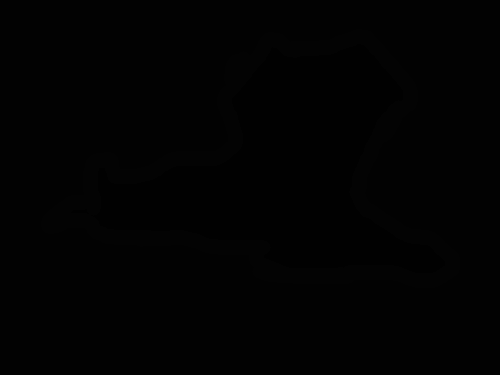

beagle_88.png


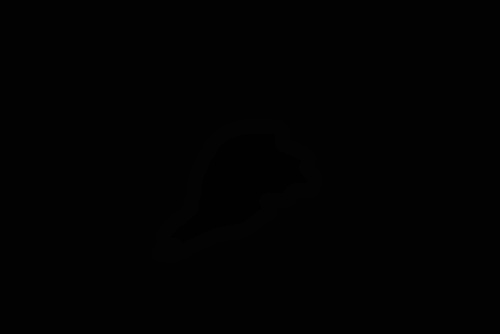

Egyptian_Mau_23.png


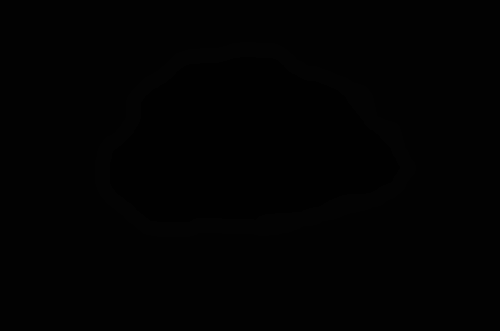

american_bulldog_143.png


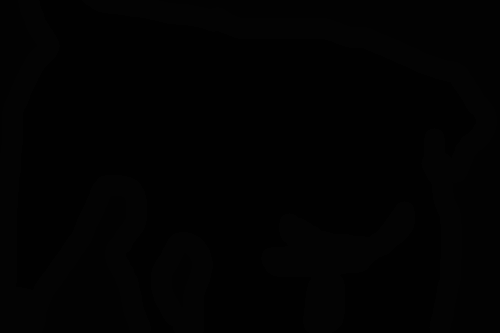

In [92]:
import os
from IPython.display import Image

folder_path = "./annotations/trimaps"
count=0
for filename in os.listdir(folder_path):

    if (filename.endswith(".jpg") or filename.endswith(".png")) and count<5:
        print(filename)
        display(Image(filename=os.path.join(folder_path, filename)))
    count+=1


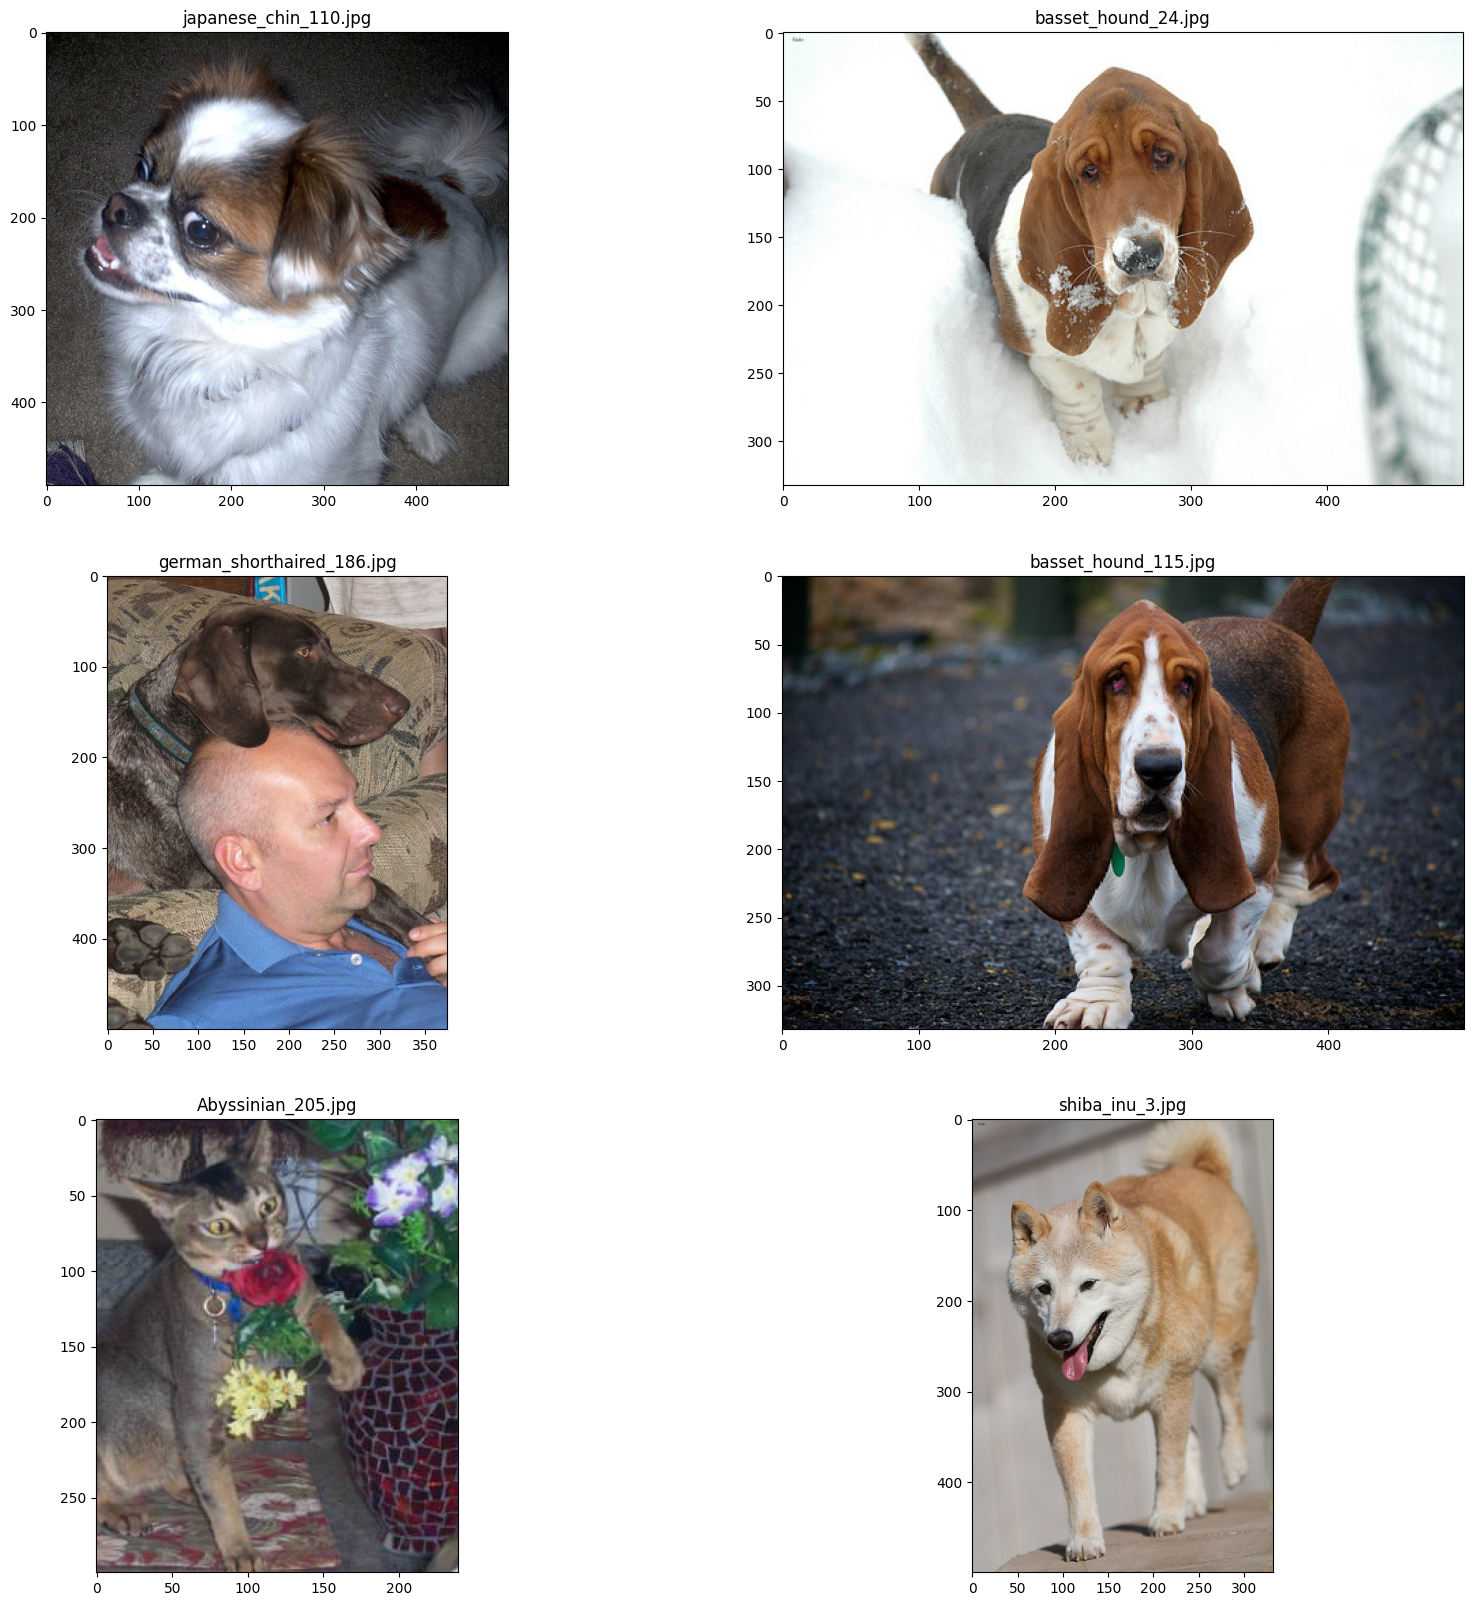

In [93]:
import os
from IPython.display import Image, display
from PIL import Image as Img
import matplotlib.pyplot as plt


folder_path = "./images"
limit = 6 # set the limit here
count = 0

images = []
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        images.append(os.path.join(folder_path, filename))
        count += 1
        if count == limit:
            break

rows = (len(images) // 3) + 1
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(20, 20))
axs = axs.flatten()

for img_path, ax in zip(images, axs):
    with Img.open(img_path) as img:
        ax.imshow(img)
        ax.set_title(os.path.basename(img_path))

plt.show()


# Generators

In [133]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  """
  files : list ,it is include img filename
  ['japanese_chin_110.jpg',
 'basset_hound_24.jpg',
 'german_shorthaired_186.jpg',
 'basset_hound_115.jpg',
 'Abyssinian_205.jpg',
 'shiba_inu_3.jpg',
 'pomeranian_53.jpg',
 'Russian_Blue_194.jpg',
 'american_pit_bull_terrier_96.jpg',
 'english_setter_129.jpg']
 """

  while True:

    #extract a random batch .it is array include 32 filename of img
    """
    example:
    batch =['japanese_chin_110.jpg','basset_hound_24.jpg']
    """
    batch = np.random.choice(files, size = batch_size)

    #variables for collecting batches of inputs and outputs
    batch_x = []
    batch_y = []


    for f in batch: # iterative each filename in batch list

        #get the masks. Note that masks are png files
        mask = Img.open(f'annotations/trimaps/{f[:-4]}.png') # f -> 'japanese_chin_110.jpg' to f[:-4] -> 'japanese_chin_110'

        mask = np.array(mask.resize(sz))


        #preprocess the mask
        mask[mask >= 2] = 0
        mask[mask != 0 ] = 1

        batch_y.append(mask)

        #preprocess the raw images
        raw = Img.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)


In [134]:
all_files = os.listdir('images')
all_files[:10]

['japanese_chin_110.jpg',
 'basset_hound_24.jpg',
 'german_shorthaired_186.jpg',
 'basset_hound_115.jpg',
 'Abyssinian_205.jpg',
 'shiba_inu_3.jpg',
 'pomeranian_53.jpg',
 'Russian_Blue_194.jpg',
 'american_pit_bull_terrier_96.jpg',
 'english_setter_129.jpg']

In [135]:
# batc = np.random.choice(all_files[:10], size = 2)
# print(batc)
# for f in batc:
#     print(f[:--10])

In [136]:
np.array(all_files).shape,len(all_files)

((7390,), 7390)

In [137]:
shuffle(all_files)

all_files[:10]


['pomeranian_136.jpg',
 'beagle_151.jpg',
 'basset_hound_49.jpg',
 'beagle_16.jpg',
 'Bengal_7.jpg',
 'english_cocker_spaniel_109.jpg',
 'basset_hound_145.jpg',
 'Ragdoll_150.jpg',
 'Siamese_106.jpg',
 'american_pit_bull_terrier_191.jpg']

In [138]:
split = int(0.90 * len(all_files)) # test ,train split value
split

6651

In [139]:
#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]
len(train_files),len(test_files)

(6651, 739)

In [140]:
batch_size = 32
train_generator = image_generator(train_files, batch_size = batch_size)
type(train_generator)


generator

In [141]:
test_generator  = image_generator(test_files, batch_size = batch_size)
test_generator

<generator object image_generator at 0x7f612994a650>

In [142]:
x, y= next(train_generator)# use for get bachx and bachy

In [143]:
x.shape,x.ndim

((32, 256, 256, 3), 4)

In [144]:
y.shape,y.ndim

((32, 256, 256, 1), 4)

img : (256, 256, 3)
mask: (256, 256, 1)
mask squeeze: (256, 256)
mask 3stack: (256, 256, 3)
img concanated: (256, 768, 3)


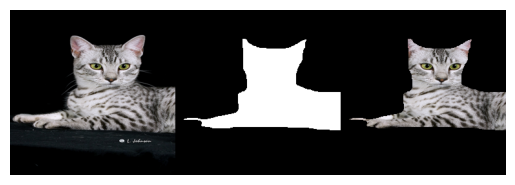

In [145]:
plt.axis('off')
img = x[0]
print("img :",img.shape)
print("mask:",y[0].shape)
msk = y[0].squeeze()
print("mask squeeze:",msk.shape)
msk = np.stack((msk,)*3, axis=-1)
print("mask 3stack:",msk.shape)
img_concat=np.concatenate([img, msk, img*msk], axis = 1)
print("img concanated:",img_concat.shape)
plt.imshow(img_concat )

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [146]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.math.logical_and(tf.math.equal(yt0, 1), tf.math.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.math.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [147]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x

  #down sampling
  filter = 8
  layers = []

  for i in range(0, 6):
    x = Conv2D(filter, 3, activation='relu', padding='same') (x)
    x = Conv2D(filter, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    filter = filter*2
  filter2 = 64

  #bottleneck
  j = len(layers) - 1
  x = Conv2D(filter, 3, activation='relu', padding='same') (x)
  x = Conv2D(filter, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(filter2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1

  #upsampling
  for i in range(0, 5):
    filter2 = filter2//2
    filter = filter // 2
    x = Conv2D(filter, 3, activation='relu', padding='same') (x)
    x = Conv2D(filter, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(filter2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1


  #classification
  x = Conv2D(filter, 3, activation='relu', padding='same') (x)
  x = Conv2D(filter, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  #model creation
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])

  return model

In [148]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions

In [151]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))

        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Img.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        #predict the mask
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1
        msk[msk < 0.5] = 0

        #show the mask and the segmented image
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

<ipython-input-152-f41b8c0b9612>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


Epoch 1/30
1/1 [==============================] - 1s 1s/step


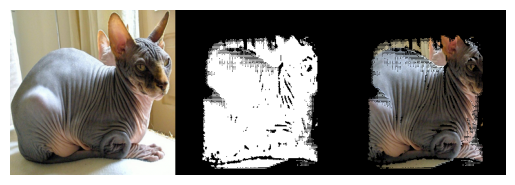

207/207 [==============================] - 107s 516ms/step - loss: 0.5337 - mean_iou: 0.0324 - val_loss: 0.4872 - val_mean_iou: 0.4683
Epoch 2/30
1/1 [==============================] - 0s 24ms/step


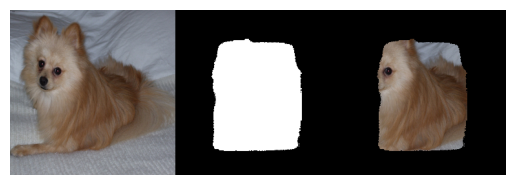

207/207 [==============================] - 100s 485ms/step - loss: 0.4735 - mean_iou: 0.4107 - val_loss: 0.4253 - val_mean_iou: 0.4847
Epoch 3/30
1/1 [==============================] - 0s 23ms/step


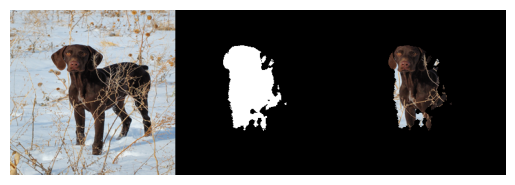

207/207 [==============================] - 98s 476ms/step - loss: 0.4473 - mean_iou: 0.4502 - val_loss: 0.4057 - val_mean_iou: 0.4680
Epoch 4/30
1/1 [==============================] - 0s 22ms/step


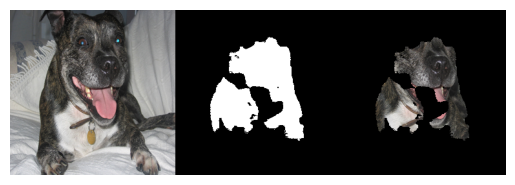

207/207 [==============================] - 99s 477ms/step - loss: 0.4147 - mean_iou: 0.4816 - val_loss: 0.3797 - val_mean_iou: 0.5010
Epoch 5/30
1/1 [==============================] - 0s 24ms/step


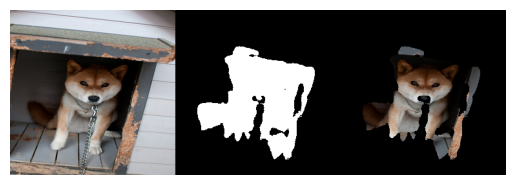

207/207 [==============================] - 98s 477ms/step - loss: 0.3892 - mean_iou: 0.5269 - val_loss: 0.3429 - val_mean_iou: 0.5620
Epoch 6/30
1/1 [==============================] - 0s 25ms/step


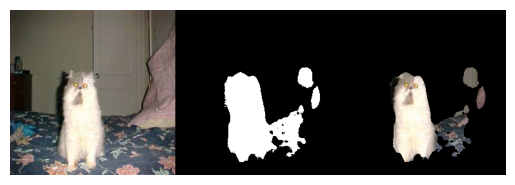

207/207 [==============================] - 99s 481ms/step - loss: 0.3596 - mean_iou: 0.5667 - val_loss: 0.3397 - val_mean_iou: 0.6110
Epoch 7/30
1/1 [==============================] - 0s 24ms/step


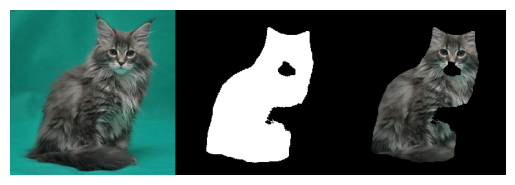

207/207 [==============================] - 99s 478ms/step - loss: 0.3346 - mean_iou: 0.5966 - val_loss: 0.2982 - val_mean_iou: 0.6356
Epoch 8/30
1/1 [==============================] - 0s 24ms/step


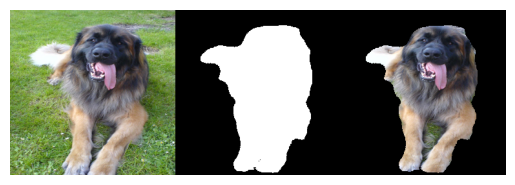

207/207 [==============================] - 100s 484ms/step - loss: 0.3057 - mean_iou: 0.6333 - val_loss: 0.3703 - val_mean_iou: 0.6025
Epoch 9/30
1/1 [==============================] - 0s 25ms/step


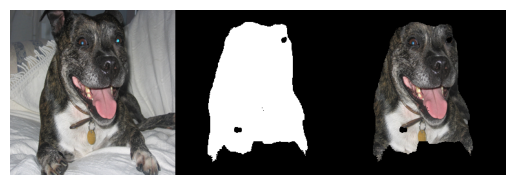

207/207 [==============================] - 99s 480ms/step - loss: 0.2889 - mean_iou: 0.6592 - val_loss: 0.2485 - val_mean_iou: 0.7018
Epoch 10/30
1/1 [==============================] - 0s 24ms/step


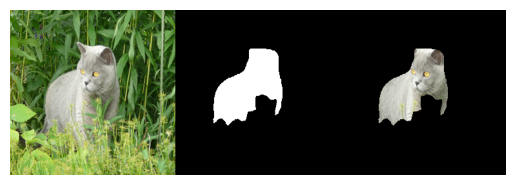

207/207 [==============================] - 100s 486ms/step - loss: 0.2619 - mean_iou: 0.6860 - val_loss: 0.2544 - val_mean_iou: 0.7017
Epoch 11/30
1/1 [==============================] - 0s 24ms/step


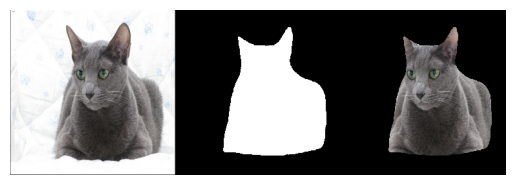

207/207 [==============================] - 101s 487ms/step - loss: 0.2535 - mean_iou: 0.6980 - val_loss: 0.2396 - val_mean_iou: 0.7231
Epoch 12/30
1/1 [==============================] - 0s 25ms/step


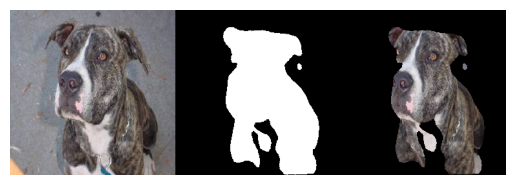

207/207 [==============================] - 99s 479ms/step - loss: 0.2368 - mean_iou: 0.7175 - val_loss: 0.2327 - val_mean_iou: 0.7070
Epoch 13/30
1/1 [==============================] - 0s 33ms/step


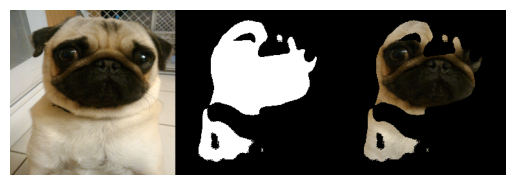

207/207 [==============================] - 98s 477ms/step - loss: 0.2244 - mean_iou: 0.7331 - val_loss: 0.2832 - val_mean_iou: 0.6121
Epoch 14/30
1/1 [==============================] - 0s 23ms/step


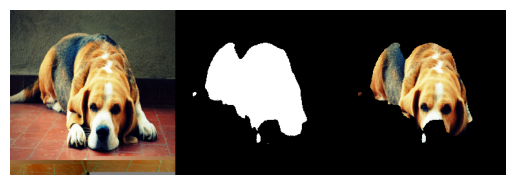

207/207 [==============================] - 98s 475ms/step - loss: 0.2142 - mean_iou: 0.7446 - val_loss: 0.2265 - val_mean_iou: 0.7302
Epoch 15/30
1/1 [==============================] - 0s 22ms/step


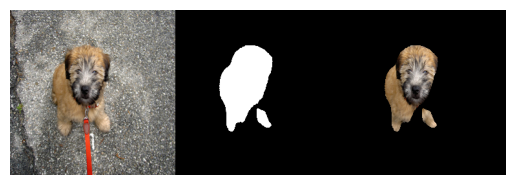

207/207 [==============================] - 97s 470ms/step - loss: 0.2005 - mean_iou: 0.7592 - val_loss: 0.2314 - val_mean_iou: 0.7442
Epoch 16/30
1/1 [==============================] - 0s 22ms/step


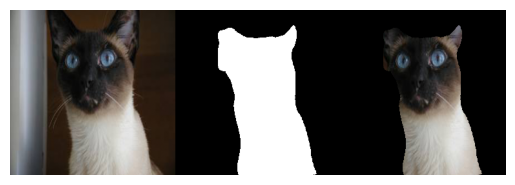

207/207 [==============================] - 99s 478ms/step - loss: 0.1981 - mean_iou: 0.7651 - val_loss: 0.2079 - val_mean_iou: 0.7431
Epoch 17/30
1/1 [==============================] - 0s 34ms/step


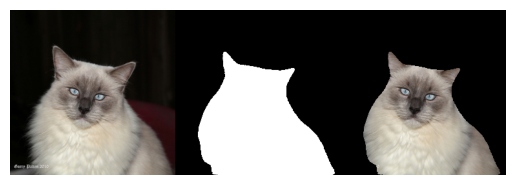

207/207 [==============================] - 99s 478ms/step - loss: 0.1862 - mean_iou: 0.7777 - val_loss: 0.1984 - val_mean_iou: 0.7635
Epoch 18/30
1/1 [==============================] - 0s 24ms/step


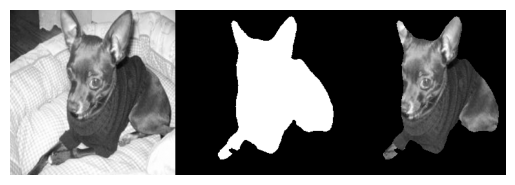

207/207 [==============================] - 99s 482ms/step - loss: 0.1777 - mean_iou: 0.7847 - val_loss: 0.2012 - val_mean_iou: 0.7429
Epoch 19/30
1/1 [==============================] - 0s 26ms/step


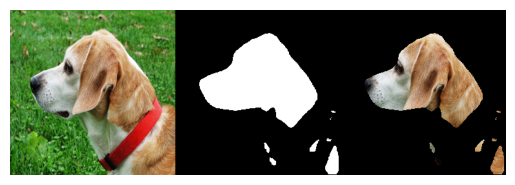

207/207 [==============================] - 99s 480ms/step - loss: 0.1690 - mean_iou: 0.7927 - val_loss: 0.1854 - val_mean_iou: 0.7773
Epoch 20/30
1/1 [==============================] - 0s 27ms/step


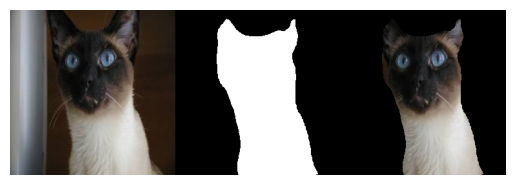

207/207 [==============================] - 98s 474ms/step - loss: 0.1579 - mean_iou: 0.8062 - val_loss: 0.2055 - val_mean_iou: 0.7799
Epoch 21/30
1/1 [==============================] - 0s 22ms/step


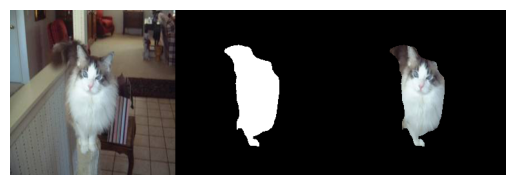

207/207 [==============================] - 96s 466ms/step - loss: 0.1566 - mean_iou: 0.8062 - val_loss: 0.2021 - val_mean_iou: 0.7626
Epoch 22/30
1/1 [==============================] - 0s 23ms/step


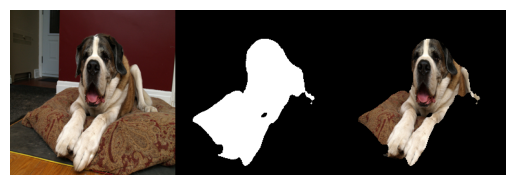

207/207 [==============================] - 97s 471ms/step - loss: 0.1519 - mean_iou: 0.8167 - val_loss: 0.1910 - val_mean_iou: 0.7713
Epoch 23/30
1/1 [==============================] - 0s 23ms/step


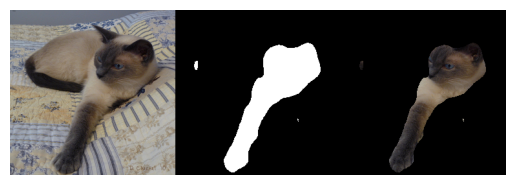

207/207 [==============================] - 98s 473ms/step - loss: 0.1417 - mean_iou: 0.8230 - val_loss: 0.2236 - val_mean_iou: 0.7673
Epoch 24/30
1/1 [==============================] - 0s 23ms/step


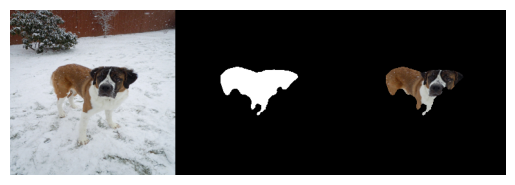

207/207 [==============================] - 97s 467ms/step - loss: 0.1415 - mean_iou: 0.8267 - val_loss: 0.2032 - val_mean_iou: 0.7766
Epoch 25/30
1/1 [==============================] - 0s 23ms/step


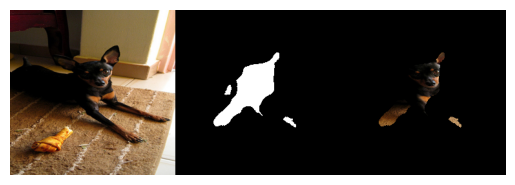

207/207 [==============================] - 98s 474ms/step - loss: 0.1352 - mean_iou: 0.8309 - val_loss: 0.1807 - val_mean_iou: 0.7979
Epoch 26/30
1/1 [==============================] - 0s 25ms/step


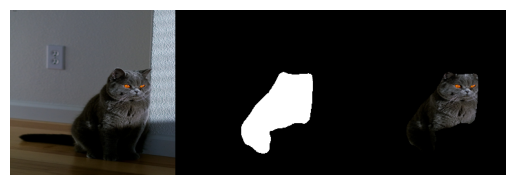

207/207 [==============================] - 99s 481ms/step - loss: 0.1307 - mean_iou: 0.8391 - val_loss: 0.1917 - val_mean_iou: 0.7889
Epoch 27/30
1/1 [==============================] - 0s 32ms/step


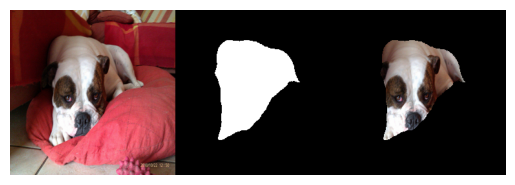

207/207 [==============================] - 98s 476ms/step - loss: 0.1236 - mean_iou: 0.8440 - val_loss: 0.1849 - val_mean_iou: 0.7871
Epoch 28/30
1/1 [==============================] - 0s 24ms/step


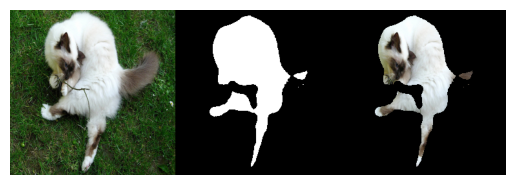

207/207 [==============================] - 98s 473ms/step - loss: 0.1167 - mean_iou: 0.8519 - val_loss: 0.1867 - val_mean_iou: 0.7880
Epoch 29/30
1/1 [==============================] - 0s 22ms/step


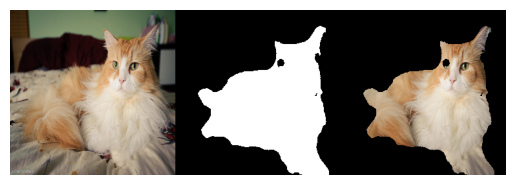

207/207 [==============================] - 100s 485ms/step - loss: 0.1195 - mean_iou: 0.8503 - val_loss: 0.2059 - val_mean_iou: 0.7717
Epoch 30/30
1/1 [==============================] - 0s 23ms/step


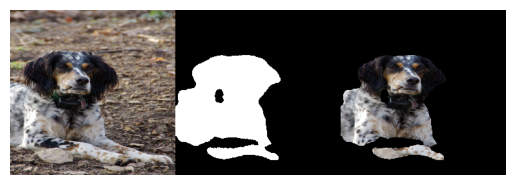

207/207 [==============================] - 100s 483ms/step - loss: 0.1145 - mean_iou: 0.8547 - val_loss: 0.2075 - val_mean_iou: 0.7825


In [152]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator,
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 1)

# Testing

In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

1/1 [==============================] - 0s 26ms/step


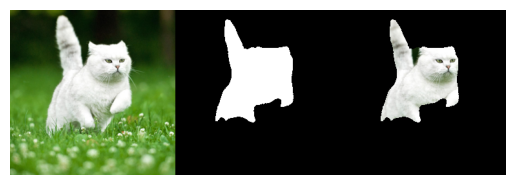

In [153]:
raw = Img.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

#show the mask and the segmented image
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

